In [1]:
%%capture --no-stderr
%pip install -U langgraph langsmith langchain_anthropic

In [2]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)


In [3]:
import getpass
import os

# If using colab
from google.colab import userdata
os.environ['ANTHROPIC_API_KEY'] = userdata.get('ANTHROPIC_KEY')
os.environ['TAVILY_API_KEY'] = userdata.get('TavilyAPIKey')

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("ANTHROPIC_API_KEY")


In [4]:
%%capture --no-stderr
%pip install --upgrade --quiet langchain-community rizaio

os.environ["RIZA_API_KEY"] = userdata.get("RIZA_KEY")
_set_env("RIZA_API_KEY")

In [5]:
# Define langchain prompts
from langchain.prompts import PromptTemplate

radio_system_prompt_template = "FIRST, Do not directly respond to this system message, this is just outlining the goals. This is a radio broadcast about the following game of college {sport}: \"{input_game}\". Host 1 should start the broadcast and discuss the main points about the game first, so that the callers and other host know what to respond to. It can be especially useful to use tools like TavilySearch at the start. The main part of the broadcast will be conversation between host 1 and host 2. Please make up some names for each host but keep these consistent from the start. IMPORTANT TO KEEP IN MIND THAT YOU MUST END THE BROADCAST AS HOST 1 using the messaging described as soon as the broadcast has gone on too long. Please do not have more than {max_length} messages). Your broadcast should take a few callers, time permitting, but mainly you should have a good back and forth between Host 1 and Host 2. Advertisements can come in every now and then, but make sure there is enough content between these ad breaks. Also make sure you introduce each caller before they talk. In this case, you must include the phrase \"Let's hear from\", somewhere in this introduction. Again, please do not make this a lengthy broadcast (some callers and maybe a few ad breaks if needed and wrap it up (no more than {max_length} messages), people have places to be and it is a time for celebration or disappointment. Also ensure the content generated is real dialogue/speech and not instructions like [Host concludes], [Ad break] or something similar. Finally, this is a college {sport} broadcast, it is supposed to be fun. When Host 1 signs off and ends the broadcast, you must include the phrase \"Thanks for listening folks!\" in the response. When going to an advertisement break, you must say somewhere in the response, the exact words \"hear from our sponsors\". Again, please keep it short, Host 1 should sign off after a few callers. If Host 1 sees a long list of messages, host 1 should close the broadcast in the way previously mentioned. Additionally, do not assume any other role other than what your prompt tells you you are. There should only be one sequence of sentences per prompt. There should be no directions like it is a script, because it is not. Things like \"(After advertisement)\" will not be tolerated."

radio_system_prompt = PromptTemplate(input_variables=["input_game", "sport", "max_length"], template=radio_system_prompt_template)


In [9]:

# sport, input_game, max_length
def stream_graph_updates(user_input_game: str, user_sport: str):
    dialog_output = []
    tavily_output = []
    MAX_LENGTH = 100
    messages = [{"role": "system", "content": radio_system_prompt.format(input_game=user_input_game, sport=user_sport, max_length=MAX_LENGTH)}]
    for event in graph.stream({"messages": messages}, {"recursion_limit": MAX_LENGTH + 50}):
        for value in event.values():
            try:
              speaker , content = (value["messages"][-1].content).split(":", 1)
              if "[{\"title" in speaker:
                  # Most likely tavily search
                  tavily_output.append(value["messages"][-1].content)
              else:
                  dialog_output.append((speaker, content))
                  print(f"[{speaker}]: {content}")


            except:
                continue

    return dialog_output, tavily_output

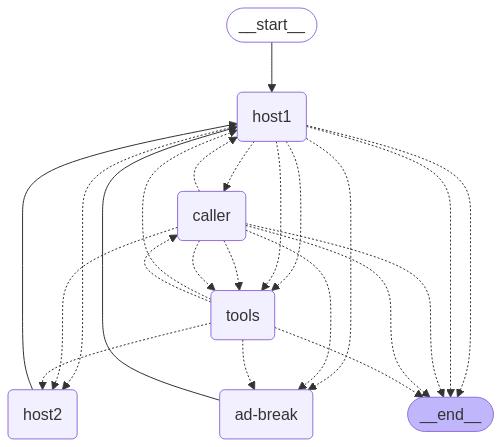

In [13]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

from langgraph.prebuilt import ToolNode, tools_condition
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.tools.riza.command import ExecPython


class State(TypedDict):
    # Setting up state
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

from langchain_anthropic import ChatAnthropic

llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")

python_tool = ExecPython()
search_tool = TavilySearchResults(max_results=4)
tools = [search_tool, python_tool]
host1_llm_with_tools = llm.bind_tools(tools)
host2_llm_with_tools = llm.bind_tools(tools)
caller_llm_with_tools = llm.bind_tools(tools)
ad_break_llm_with_tools = llm


# DEFINE GLOBAL LAST_CALLED_TOOLS
LAST_CALLED_TOOLS = "host1"

HOST_1_Default_Final_message = "That's all for today folks. Thanks for listening to the postgame show!"
def host_1_continue(state):
    global LAST_CALLED_TOOLS
    messages = state['messages']
    last_message = messages[-1]

    # If the LLM makes a tool call, then we route to the "tools" node
    if last_message.tool_calls:
        LAST_CALLED_TOOLS = "host1"
        return "tools"
    elif ("thanks for listening") in last_message.content.lower():
        return END
    elif ("hear from our sponsors") in last_message.content.lower():
        return "ad-break"
    elif ("let's hear from") in last_message.content.lower():
        return "caller"
    else:
        return "host2"

def caller_continue(state):
    global LAST_CALLED_TOOLS
    messages = state['messages']
    last_message = messages[-1]

    # If the LLM makes a tool call, then we route to the "tools" node
    if last_message.tool_calls:
        LAST_CALLED_TOOLS = "caller"
        return "tools"
    else:
        return "host1"

def tools_continue(state):
    global LAST_CALLED_TOOLS
    return LAST_CALLED_TOOLS



def host1(state: State):
    prompt = "You are Host 1 on a postgame radio show about a college sports game. Please feel free to use any tools provided to look up / run code on certain things about this game, especially if you do not have much background on the game (especially true for games past 2021). Continue the conversation with Host 2, respond to the caller, introduce the next caller, go into or come back from an advertisement break, and/or wrap up the radio broadcast by saying exactly \"That's all for today folks. Thanks for listening to the postgame show!\". It is important to respond to the callers and introduce these callers every now and then, but the broadcast is meant to have the hosts star. Ensure you start your reply with \"HOST 1: \" and only include your part in the response (ie do not assume the role of Host 2, Caller or anybody else). These should be short max 5 sentences before moving onto the next node. Also make sure to wrap it up after a few callers. If the broadcast has been going for a while and you notice there has been enough discussion, please end the broadcast using the messaging discussed earlier. Again, after the final caller talks, you should respond to them and then close the broadcast as previously stated with the phrase \"That's all for today folks. Thanks for listening to the postgame show!\""

    # print("HOST 1",state["messages"] + [prompt])
    content = host1_llm_with_tools.invoke(state["messages"] + [prompt])
    # print("HOST 1",content)
    return {"messages": [content]}

def host2(state: State):
    prompt = "You are Host 2 on a postgame radio show about a college sports game. Continue the conversation with Host 1. Ensure you start your reply with \"HOST 2: \" and only include your part in the response (ie do not assume the role of Host 2 or anybody else). These should be short (max 5 sentences) "
    content = host2_llm_with_tools.invoke(state["messages"] + [prompt])
    return {"messages": [content]}

def caller(state: State):
    prompt = "You are a caller on a postgame radio show about a college sports game. Introduce yourself and then discuss the game and ask questions to the hosts, and feel free to use tools to refine your questions/responses. It's always a good idea to bring up a new perspective and have \"hot takes\" based on information you gather. Be as entertaining as possible. It is however crucial to keep the same name that the Host identified you as. Callers are not supposed to be professional broadcasters so make it seem like a college sports fanatic.  Ensure you start your reply with \"CALLER: \" and only include your part in the response (ie do not assume the role of Host 2, Caller or anybody else). These should be short max 5 sentences before moving onto the next node"
    content = caller_llm_with_tools.invoke(state["messages"] + [prompt])
    return {"messages": [content]}

def advertisement(state: State):
    prompt = "You are a 30 second advertisement on a postgame radio show about a college sports game. Make it pretty generic. Ensure you start your reply with \"ADVERTISEMENT: \" and only include your part in the response (ie do not assume the role of Host 2 or anybody else). These should be short max 5 sentences before moving onto the next node. You should only respond as the advertisement nothing else"
    content = ad_break_llm_with_tools.invoke(state["messages"] + [prompt])
    return {"messages": [content]}


tool_node = ToolNode(tools=tools)

graph_builder.add_node("host1", host1)
graph_builder.add_node("host2", host2)
graph_builder.add_node("caller", caller)
graph_builder.add_node("tools", tool_node)
graph_builder.add_node("ad-break", advertisement)


graph_builder.add_edge(START, "host1")
graph_builder.add_conditional_edges("host1", host_1_continue)
graph_builder.add_edge("host2", "host1")
graph_builder.add_conditional_edges("caller", caller_continue)
graph_builder.add_conditional_edges(
    "host1",
    tools_condition, # Host 1 can use the tools
)
graph_builder.add_conditional_edges(
    "caller",
    tools_condition, # Caller can use the tools
)

graph_builder.add_conditional_edges("tools", tools_continue)

graph_builder.add_edge("ad-break", "host1")


graph = graph_builder.compile()

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
user_input_sport = input("What college sport do you want to generate a radio broadcast for: ")
user_input_game = input("What game do you want to generate a radio broadcast for: ")

dialog_output_1, tavily_output_1 = stream_graph_updates(user_input_game, user_input_sport)

In [11]:
dialog_output_1

[('HOST 1',
  " Welcome back to the Sugar Bowl postgame show, folks! I'm Jack Thompson, and what a game we just witnessed! The Louisville Cardinals pulled off a stunning upset, defeating the Florida Gators 33-23 in a thrilling matchup. Teddy Bridgewater led the Cardinals to victory, showcasing why he's one of the top quarterbacks in college football. Let's break down this unexpected turn of events with my co-host, Sarah Jenkins. Sarah, what stood out to you in this game?"),
 ('HOST 2',
  " Jack, I'm still in shock! The Cardinals came out swinging, with Terell Floyd returning an interception for a touchdown on the very first play of the game. That set the tone for Louisville's dominant performance. Teddy Bridgewater was absolutely phenomenal, picking apart Florida's vaunted defense with precision and poise. The Gators seemed caught off guard by Louisville's intensity and struggled to find their rhythm throughout the game. This upset will go down as one of the biggest in Sugar Bowl histo

In [12]:
print(tavily_output_1)


['[{"title": "Louisville 33-23 Florida (Jan 2, 2013) Final Score - ESPN", "url": "https://www.espn.com/college-football/game/_/gameId/330020057/louisville-florida", "content": "Louisville upsets Florida in Sugar Bowl stunner Terell Floyd returned an interception 38 yards for a score on the first play.", "score": 0.7872945}, {"title": "2013 Sugar Bowl Highlight Video - YouTube", "url": "https://www.youtube.com/watch?v=v8GspwXiJAM", "content": "On January 2nd, 2013, the Louisville Cardinal Football team swamped the Florida Gators 33-23 in the Allstate Sugar Bowl Classic in New", "score": 0.7742597}, {"title": "2013 Sugar Bowl: Louisville defeats #3 Florida Gators - YouTube", "url": "https://www.youtube.com/watch?v=Z31fGyJsAHA", "content": "#10 Louisville 63 vs. #2 Florida State 20 (2016): GameDay. Michael Lindsay · 78K views ; #21 Louisville VS #3 Florida | 2013 Sugar Bowl Highlights.", "score": 0.7293082}, {"title": "#21 Louisville VS #3 Florida | 2013 Sugar Bowl Highlights - YouTube", 

In [ ]:
import pickle

pickle.dump(dialog_output_1, open("dialog_output-sugar-bowl.pkl", "wb"))
pickle.dump(tavily_output_1, open("tavily_output-sugar-bowl.pkl", "wb"))

In [8]:
!pip install --upgrade google-cloud-texttospeech

  Using cached google_cloud_texttospeech-2.25.0-py2.py3-none-any.whl.metadata (5.5 kB)
  Using cached google_api_core-2.24.2-py3-none-any.whl.metadata (3.0 kB)
  Using cached grpcio_status-1.71.0-py3-none-any.whl.metadata (1.1 kB)
Using cached google_cloud_texttospeech-2.25.0-py2.py3-none-any.whl (186 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.1/160.1 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 67.7 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.70.0
    Uninstalling grpcio-1.70.0:
      Successfully uninstalled grpcio-1.70.0
  Attempting uninstall: grpcio-status
    Found existing installation: grpcio-status 1.48.2
    Uninstalling grpcio-status-1.48.2:
      

In [2]:
!gcloud init

Welcome! This command will take you through the configuration of gcloud.

Settings from your current configuration [srikhedu-gcloud-config] are:
component_manager:
  disable_update_check: 'True'
core:
  account: srikhedu@gmail.com
  project: tts-genai-chicago-radio

Pick configuration to use:
 [1] Re-initialize this configuration [srikhedu-gcloud-config] with new settings 
 [2] Create a new configuration
 [3] Switch to and re-initialize existing configuration: [default]
Please enter your numeric choice:  

Command killed by keyboard interrupt

^C


In [3]:
!gcloud auth application-default login

Go to the following link in your browser, and complete the sign-in prompts:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=764086051850-6qr4p6gpi6hn506pt8ejuq83di341hur.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fsdk.cloud.google.com%2Fapplicationdefaultauthcode.html&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login&state=g4WKIgOs1vJrC1TzyszknlFOz4K8pi&prompt=consent&token_usage=remote&access_type=offline&code_challenge=11yy5vndlC4hRjpizYB1HhmUzmnzl-9Xga36CpwyMfM&code_challenge_method=S256

Once finished, enter the verification code provided in your browser: 4/0AQSTgQGM3OoKatguVpDuSWfLEH0hpzWg45PmpsJO_HcaajwTCKEgCccpLyk-K9nISSwarw

Credentials saved to file: [/content/.config/application_default_credentials.json]

These credentials will be used by any library that requests Application Default Credentials (ADC).

Q

In [3]:
!gcloud auth application-default set-quota-project tts-genai-radio

Run $gcloud auth application-default set-quota-project to insert a quota project to ADC.
ERROR: (gcloud.auth.application-default.set-quota-project) Cannot add the project "tts-genai-radio" to application default credentials (ADC) as a quota project because the account in ADC does not have the "serviceusage.services.use" permission on this project.


In [4]:
def list_voices():
    """Lists the available voices."""
    from google.cloud import texttospeech

    client = texttospeech.TextToSpeechClient()

    # Performs the list voices request
    voices = client.list_voices()

    for voice in voices.voices:
        # Display the voice's name. Example: tpc-vocoded
        print(f"Name: {voice.name}")

        # Display the supported language codes for this voice. Example: "en-US"
        for language_code in voice.language_codes:
            print(f"Supported language: {language_code}")

        ssml_gender = texttospeech.SsmlVoiceGender(voice.ssml_gender)

        # Display the SSML Voice Gender
        print(f"SSML Voice Gender: {ssml_gender.name}")

        # Display the natural sample rate hertz for this voice. Example: 24000
        print(f"Natural Sample Rate Hertz: {voice.natural_sample_rate_hertz}\n")

list_voices()

Name: af-ZA-Standard-A
Supported language: af-ZA
SSML Voice Gender: FEMALE
Natural Sample Rate Hertz: 24000

Name: am-ET-Standard-A
Supported language: am-ET
SSML Voice Gender: FEMALE
Natural Sample Rate Hertz: 24000

Name: am-ET-Standard-B
Supported language: am-ET
SSML Voice Gender: MALE
Natural Sample Rate Hertz: 24000

Name: am-ET-Wavenet-A
Supported language: am-ET
SSML Voice Gender: FEMALE
Natural Sample Rate Hertz: 24000

Name: am-ET-Wavenet-B
Supported language: am-ET
SSML Voice Gender: MALE
Natural Sample Rate Hertz: 24000

Name: ar-XA-Chirp3-HD-Aoede
Supported language: ar-XA
SSML Voice Gender: FEMALE
Natural Sample Rate Hertz: 24000

Name: ar-XA-Chirp3-HD-Charon
Supported language: ar-XA
SSML Voice Gender: MALE
Natural Sample Rate Hertz: 24000

Name: ar-XA-Chirp3-HD-Fenrir
Supported language: ar-XA
SSML Voice Gender: MALE
Natural Sample Rate Hertz: 24000

Name: ar-XA-Chirp3-HD-Kore
Supported language: ar-XA
SSML Voice Gender: FEMALE
Natural Sample Rate Hertz: 24000

Name: ar

In [3]:
import pickle

dialog_output = pickle.load(open("dialog_output.pkl", "rb"))

In [1]:
!pip3 install pydub

In [6]:
# !pip3 install "google-cloud-texttospeech<2.0.0"

In [7]:
"""Synthesizes speech for multiple speakers.
Make sure to be working in a virtual environment.
"""
import random

from pydub import AudioSegment

second_of_silence = AudioSegment.silent(duration=1000) # from stack overflow

from google.cloud import texttospeech

# Instantiates a client
single_client = texttospeech.TextToSpeechClient()

idx = 0

for speaker, speech in dialog_output:
    idx += 1
    wait_for_input = input(f"Press enter to continue with {idx}, or quit with q")
    if wait_for_input == "q":
        break

    voice_name = None
    output_filename = None


    synthesis_input = texttospeech.SynthesisInput(text=speech.strip())

    if speaker == "HOST 1":
        voice_name = "en-US-Casual-K"
        output_filename = f"{idx}-host-1.mp3"

    elif speaker == "HOST 2":
        voice_name = "en-US-Chirp-HD-F"

        output_filename = f"{idx}-host-2.mp3"



    if speaker == "CALLER":

        random_int = random.randint(1, 3)
        if random_int == 1:
            voice_name = "en-US-Chirp3-HD-Puck"
        elif random_int == 2:
            voice_name = "en-US-Chirp3-HD-Zephyr"
        else:
            voice_name = "en-US-Chirp3-HD-Orus"

        output_filename = f"{idx}-caller.mp3"

    if speaker == "ADVERTISEMENT":
        random_int = random.randint(1, 3)
        if random_int == 1:
            voice_name = "en-US-Neural2-A"
        elif random_int == 2:
            voice_name = "en-US-Neural2-C"
        else:
            voice_name = "en-US-Neural2-D"

        output_filename = f"{idx}-ad.mp3"

    # Build the voice request, select the language code ("en-US") and the ssml
    # voice gender ("neutral")
    voice = texttospeech.VoiceSelectionParams(
        language_code="en-US", name=voice_name
    )

    # Select the type of audio file you want returned
    audio_config = texttospeech.AudioConfig(
        audio_encoding=texttospeech.AudioEncoding.MP3
    )

    # Perform the text-to-speech request on the text input with the selected
    # voice parameters and audio file type
    response = single_client.synthesize_speech(
        input=synthesis_input, voice=voice, audio_config=audio_config
    )

    # The response's audio_content is binary.
    with open(output_filename, "wb") as out:
        # Write the response to the output file.
        out.write(response.audio_content)
        print(f'Audio content written to file "{output_filename}')


Press enter to continue with 1, or quit with q
Audio content written to file "1-host-1.mp3
Press enter to continue with 2, or quit with q
Audio content written to file "2-host-2.mp3
Press enter to continue with 3, or quit with q
Audio content written to file "3-host-1.mp3
Press enter to continue with 4, or quit with q
Audio content written to file "4-caller.mp3
Press enter to continue with 5, or quit with q
Audio content written to file "5-host-1.mp3
Press enter to continue with 6, or quit with q
Audio content written to file "6-host-2.mp3
Press enter to continue with 7, or quit with q
Audio content written to file "7-host-1.mp3
Press enter to continue with 8, or quit with q
Audio content written to file "8-caller.mp3
Press enter to continue with 9, or quit with q
Audio content written to file "9-host-1.mp3
Press enter to continue with 10, or quit with q
Audio content written to file "10-ad.mp3
Press enter to continue with 11, or quit with q
Audio content written to file "11-host-1.mp3

In [ ]:

# """Synthesizes speech for multiple speakers.
# Make sure to be working in a virtual environment.
# """

# from pydub import AudioSegment

# second_of_silence = AudioSegment.silent(duration=1000) # from stack overflow

# from google.cloud import texttospeech_v1beta1 as texttospeech_multiturn
# from google.cloud import texttospeech

# # Instantiates a client
# multi_turn_client = texttospeech_multiturn.TextToSpeechClient()
# single_client = texttospeech.TextToSpeechClient()

# idx = 0
# last_host_speaker = False
# host_turns = []

# for speaker, speech in dialog_output:
#   idx += 1
#   wait_for_input = input(f"Press enter to continue with {idx}, or quit with q")
#   if wait_for_input == "q":
#     break
#   if speaker == "HOST 1" or speaker == "HOST 2":
#       last_host_speaker = True
#       this_speaker = "R" if speaker == "HOST 1" else "S"

#       host_turns.append(texttospeech_multiturn.MultiSpeakerMarkup.Turn(text=speech.strip(), speaker="R"))

#   # If there were previous last host turns, use multi turn model and generate audio
#   if last_host_speaker:
#       last_host_speaker = False
#       multi_speaker_markup = texttospeech_multiturn.MultiSpeakerMarkup(turns=host_turns)

#       # Set the text input to be synthesized
#       synthesis_input = texttospeech_multiturn.SynthesisInput(
#           multi_speaker_markup=multi_speaker_markup
#       )

#       # Build the voice request, select the language code ('en-US') and the voice
#       voice = texttospeech_multiturn.VoiceSelectionParams(
#           language_code="en-US", name="en-US-Studio-MultiSpeaker"
#       )

#       # Select the type of audio file you want returned
#       audio_config = texttospeech_multiturn.AudioConfig(
#           audio_encoding=texttospeech.AudioEncoding.MP3
#       )

#       # Perform the text-to-speech request on the text input with the selected
#       # voice parameters and audio file type
#       response = multi_turn_client.synthesize_speech(
#           input=synthesis_input, voice=voice, audio_config=audio_config
#       )

#       output_filename = f"{idx}-host.mp3"
#       # The response's audio_content is binary.
#       with open(output_filename, "wb") as out:
#           # Write the response to the output file.
#           out.write(response.audio_content)
#           print(f'Audio content written to file {output_filename}')

#       host_turns = []



#   if speaker == "CALLER":
#       #
#       synthesis_input = texttospeech.SynthesisInput(text=speech.strip())

#       # Build the voice request, select the language code ("en-US") and the ssml
#       # voice gender ("neutral")
#       voice = texttospeech.VoiceSelectionParams(
#           language_code="en-US", name="en-US-Chirp3-HD-Puck", ssml_gender=texttospeech.SsmlVoiceGender.NEUTRAL
#       )

#       # Select the type of audio file you want returned
#       audio_config = texttospeech.AudioConfig(
#           audio_encoding=texttospeech.AudioEncoding.MP3
#       )

#       # Perform the text-to-speech request on the text input with the selected
#       # voice parameters and audio file type
#       response = single_client.synthesize_speech(
#           input=synthesis_input, voice=voice, audio_config=audio_config
#       )

#       # The response's audio_content is binary.
#       with open(f"{idx}-caller.mp3", "wb") as out:
#           # Write the response to the output file.
#           out.write(response.audio_content)
#           print(f'Audio content written to file "{idx}-caller.mp3"')
#   if speaker == "ADVERTISEMENT":
#       #
#       synthesis_input = texttospeech.SynthesisInput(text=speech.strip())

#       # Build the voice request, select the language code ("en-US") and the ssml
#       # voice gender ("neutral")
#       voice = texttospeech.VoiceSelectionParams(
#           language_code="en-US", ssml_gender=texttospeech.SsmlVoiceGender.NEUTRAL
#       )

#       # Select the type of audio file you want returned
#       audio_config = texttospeech.AudioConfig(
#           audio_encoding=texttospeech.AudioEncoding.MP3
#       )

#       # Perform the text-to-speech request on the text input with the selected
#       # voice parameters and audio file type
#       response = single_client.synthesize_speech(
#           input=synthesis_input, voice=voice, audio_config=audio_config
#       )

#       # The response's audio_content is binary.
#       with open(f"{idx}-ad.mp3", "wb") as out:
#           # Write the response to the output file.
#           out.write(response.audio_content)
#           print(f'Audio content written to file "{idx}-ad.mp3"')

#   """

In [11]:
from pydub import AudioSegment
import os

second_of_silence = AudioSegment.silent(duration=1000) # from stack overflow
combined_audio_postgame = AudioSegment.empty()
for i in range (1, 16):
    if i != 1:
        combined_audio_postgame += second_of_silence


    corrected_filename = [entry for entry in os.listdir('.') if entry.startswith(f"{i}-") and os.path.isfile(entry) and entry.endswith(".mp3")][0]
    print(corrected_filename)

    if "caller" or "ad" in corrected_filename:
        combined_audio_postgame += second_of_silence # another second for ad breaks and callers

    combined_audio_postgame += AudioSegment.from_mp3(corrected_filename)





1-host-1.mp3
2-host-2.mp3
3-host-1.mp3
4-caller.mp3
5-host-1.mp3
6-host-2.mp3
7-host-1.mp3
8-caller.mp3
9-host-1.mp3
10-ad.mp3
11-host-1.mp3
12-caller.mp3
13-host-1.mp3
14-caller.mp3
15-host-1.mp3


In [12]:
# Export the combined audio to a new file
combined_audio_postgame.export("postgame-show-louisville-stanford.mp3", format="mp3")

<_io.BufferedRandom name='postgame-show-louisville-stanford.mp3'>

In [8]:
# prompt: mount drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [13]:
# prompt: save files to drive "MyDrive/Genai Project

!mkdir -p /content/drive/MyDrive/Genai\ Project
!cp *.pkl /content/drive/MyDrive/Genai\ Project/
!cp *.mp3 /content/drive/MyDrive/Genai\ Project/


In [ ]:
# 3:30 of audio

In [ ]:
# SO FAR ALL OF THIS WORK IS BORROWED FROM agents_with_langgraph.ipynb